## Simpsons Family: Image Classification

Dataset Source: https://www.kaggle.com/datasets/williamu32/dataset-bart-or-homer

##### Install Necessary Libraries Not Already Installed

In [1]:
%pip install datasets transformers


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [2]:
import os, sys, random
os.environ['TOKENIZERS_PARALLELISM']='false'

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, load_metric, concatenate_datasets

import transformers
from transformers import Trainer, TrainingArguments
from transformers import ViTForImageClassification, ViTFeatureExtractor

import torch

NOTE: Redirects are currently not supported in Windows or MacOs.


##### Display Versions of Relevant Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.23.3
        Pandas: 1.5.0
      Datasets: 2.5.2
  Transformers: 4.22.2
         Torch: 1.12.1


##### Ingest Dataset

In [4]:
dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Documents/nlpnn/Datasets/Simpsons Main Characters/family_members", 
                        drop_labels=False)

print(dataset['train'])
print(dataset['train'][0])
print(dataset['train'][-1])

print(dataset['test'])
print(dataset['test'][0])
print(dataset['test'][-1])

A Jupyter Widget

A Jupyter Widget

Using custom data configuration default-bc2d5659e57e1902
Found cached dataset imagefolder (/Users/briandunn/.cache/huggingface/datasets/imagefolder/default-bc2d5659e57e1902/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


A Jupyter Widget

Dataset({
    features: ['image', 'label'],
    num_rows: 5956
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x464 at 0x7FC959B815B0>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=576x432 at 0x7FC959B81DC0>, 'label': 4}
Dataset({
    features: ['image', 'label'],
    num_rows: 404
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x480 at 0x7FC959B816D0>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x464 at 0x7FC959B81700>, 'label': 4}


##### Display Grid of Examples From Each Class to Gain Better Picture of Data

In [5]:
def show_grid_of_examples(ds, 
                          seed: int = 42, 
                          examples_per_class: int = 3, 
                          size=(350, 350)):
    '''
    This function displays a few pictures
    from each class in the dataset.
    '''
    w, h = size
    labels = ds['train'].features['label'].names
    grid = PIL.Image.new(mode='RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("Chalkduster.ttf", 24)
    
    for label_id, label in enumerate(labels):
        # filter the dataset by a single label, shuffle it, then grab a few samples
        ds_slice = ds['train'] \
                    .filter(lambda ex: ex['label'] == label_id) \
                    .shuffle(seed) \
                    .select(range(examples_per_class))
        
        # plot this label's examples in a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (0, 0, 255), font=font)
    
    return grid

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-bc2d5659e57e1902/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-0bc28894f7fe1667.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-bc2d5659e57e1902/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-4a26253a83351d0f.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-bc2d5659e57e1902/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-b14f454765cc033a.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-bc2d5659e57e1902/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-37c60bc0d6d34025.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-bc2d5

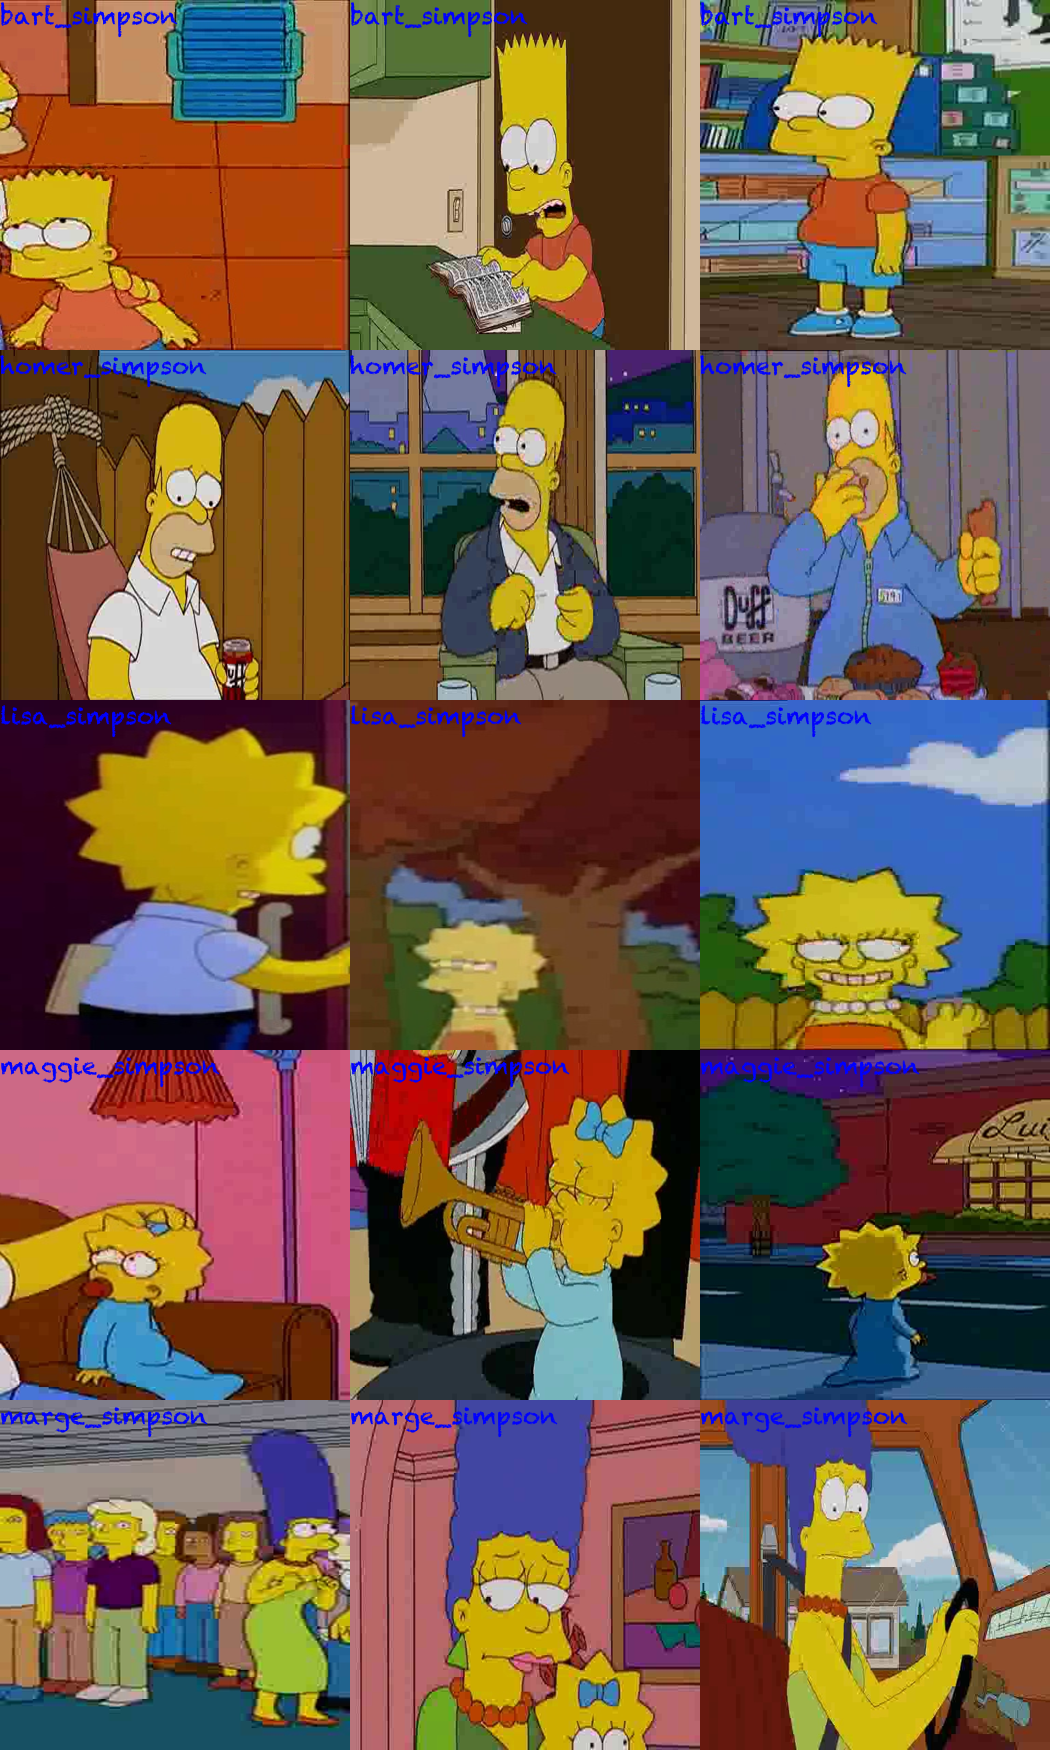

In [6]:
show_grid_of_examples(dataset, seed=42, examples_per_class=3)

##### Remember to Install git lfs & Enter HuggingFace Access Token

In [7]:
# Enter Huggingface Access Token

!git lfs install

Git LFS initialized.


##### Basic Values/Constants

In [8]:
MODEL_CKPT='google/vit-base-patch16-224-in21k'
NUM_OF_EPOCHS=3

LEARNING_RATE=2e-4
STEPS=100

BATCH_SIZE=16
DEVICE = torch.device("mps")

##### Load ViT Feature Extractor

In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_CKPT)

##### Preprocessing Dataset

In [10]:
def transform(sample_batch):
    # convert list of PIL images into pixel values
    inputs = feature_extractor([x for x in sample_batch['image']], return_tensors="pt")
    
    # prep labels
    inputs['labels'] = sample_batch['label']
    return inputs

##### Apply Transform Function to Dataset

In [11]:
prepped_ds = dataset.with_transform(transform)

#### Training & Evaluation

##### Define Data Collator

In [12]:
def data_collator(batch):
    return {
        'pixel_values' : torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch])
    }

##### Define Evaluation Metric

In [13]:
def compute_metrics(p):
    accuracy_metric = load_metric("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = load_metric("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = load_metric("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = load_metric("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }


##### Load Pretrained Model

In [14]:
labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(DEVICE)

model.config

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "bart_simpson",
    "1": "homer_simpson",
    "2": "lisa_simpson",
    "3": "maggie_simpson",
    "4": "marge_simpson"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "bart_simpson": "0",
    "homer_simpson": "1",
    "lisa_simpson": "2",
    "maggie_simpson": "3",
    "marge_simpson": "4"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.22.2"
}

##### Define Training Arguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_CKPT + "_Simpsons_Family_Members",
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    disable_tqdm=False,
    load_best_model_at_end=True,
    logging_first_step=True,
    push_to_hub=True
)

##### Instantiate Trainer

In [16]:
trainer = Trainer(
    model = model,
    args= args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset=prepped_ds['train'],
    eval_dataset=prepped_ds['test'],
    tokenizer=feature_extractor,
)

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/huggingface_hub/repository.py:705: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  warnings.warn(
Cloning https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_Simpsons_Family_Members into local empty directory.


##### Train Model

In [17]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5956
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1119


A Jupyter Widget

{'loss': 1.5773, 'learning_rate': 0.0001998212689901698, 'epoch': 0.0}


***** Running Evaluation *****
  Num examples = 404
  Batch size = 8


A Jupyter Widget

/var/folders/93/v_c2ph_17t97zdkzc4_ccjtw0000gn/T/ipykernel_35806/511222555.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
Saving model checkpoint to google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-373
Configuration saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-373/config.json


{'eval_loss': 1.0481945276260376, 'eval_accuracy': 0.7772277227722773, 'eval_Weighted F1': 0.7263266810424557, 'eval_Micro F1': 0.7772277227722773, 'eval_Macro F1': 0.7261198751167324, 'eval_Weighted Recall': 0.7772277227722773, 'eval_Micro Recall': 0.7772277227722773, 'eval_Macro Recall': 0.7777777777777778, 'eval_Weighted Precision': 0.8932723208097979, 'eval_Micro Precision': 0.7772277227722773, 'eval_Macro Precision': 0.8922355318227739, 'eval_runtime': 363.654, 'eval_samples_per_second': 1.111, 'eval_steps_per_second': 0.14, 'epoch': 1.0}


Model weights saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-373/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-373/preprocessor_config.json
Feature extractor saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/preprocessor_config.json


{'loss': 0.1598, 'learning_rate': 0.00011063449508489723, 'epoch': 1.34}


***** Running Evaluation *****
  Num examples = 404
  Batch size = 8


A Jupyter Widget

Saving model checkpoint to google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-746
Configuration saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-746/config.json


{'eval_loss': 0.3902488946914673, 'eval_accuracy': 0.905940594059406, 'eval_Weighted F1': 0.9027529236623092, 'eval_Micro F1': 0.905940594059406, 'eval_Macro F1': 0.9025589061327131, 'eval_Weighted Recall': 0.905940594059406, 'eval_Micro Recall': 0.905940594059406, 'eval_Macro Recall': 0.9060185185185186, 'eval_Weighted Precision': 0.9224004291893639, 'eval_Micro Precision': 0.905940594059406, 'eval_Macro Precision': 0.921938438296667, 'eval_runtime': 350.3954, 'eval_samples_per_second': 1.153, 'eval_steps_per_second': 0.146, 'epoch': 2.0}


Model weights saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-746/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-746/preprocessor_config.json
Feature extractor saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/preprocessor_config.json


{'loss': 0.027, 'learning_rate': 2.126899016979446e-05, 'epoch': 2.68}


***** Running Evaluation *****
  Num examples = 404
  Batch size = 8


A Jupyter Widget

Saving model checkpoint to google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-1119
Configuration saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-1119/config.json
Model weights saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-1119/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-1119/preprocessor_config.json


{'eval_loss': 0.2431316375732422, 'eval_accuracy': 0.9529702970297029, 'eval_Weighted F1': 0.9522288953284159, 'eval_Micro F1': 0.9529702970297029, 'eval_Macro F1': 0.9521097000368888, 'eval_Weighted Recall': 0.9529702970297029, 'eval_Micro Recall': 0.9529702970297029, 'eval_Macro Recall': 0.9530864197530864, 'eval_Weighted Precision': 0.9604642926098597, 'eval_Micro Precision': 0.9529702970297029, 'eval_Macro Precision': 0.9601291764998138, 'eval_runtime': 360.7329, 'eval_samples_per_second': 1.12, 'eval_steps_per_second': 0.141, 'epoch': 3.0}


Feature extractor saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/preprocessor_config.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from google/vit-base-patch16-224-in21k_Simpsons_Family_Members/checkpoint-1119 (score: 0.2431316375732422).


{'train_runtime': 48467.025, 'train_samples_per_second': 0.369, 'train_steps_per_second': 0.023, 'train_loss': 0.08599743702456394, 'epoch': 3.0}


##### Save & Log Trainer Outputs

In [18]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to google/vit-base-patch16-224-in21k_Simpsons_Family_Members
Configuration saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/config.json
Model weights saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/preprocessor_config.json
Saving model checkpoint to google/vit-base-patch16-224-in21k_Simpsons_Family_Members
Configuration saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/config.json
Model weights saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_Simpsons_Family_Members
   1ba0154..5a71883  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_Simpsons_Family_Members
   5a71883..8143d33  main -> main



***** train metrics *****
  epoch                    =         3.0
  train_loss               =       0.086
  train_runtime            = 13:27:47.02
  train_samples_per_second =       0.369
  train_steps_per_second   =       0.023


##### Evaluate Model

In [19]:
metrics = trainer.evaluate(prepped_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 404
  Batch size = 8


A Jupyter Widget

***** eval metrics *****
  epoch                   =        3.0
  eval_Macro F1           =     0.9521
  eval_Macro Precision    =     0.9601
  eval_Macro Recall       =     0.9531
  eval_Micro F1           =      0.953
  eval_Micro Precision    =      0.953
  eval_Micro Recall       =      0.953
  eval_Weighted F1        =     0.9522
  eval_Weighted Precision =     0.9605
  eval_Weighted Recall    =      0.953
  eval_accuracy           =      0.953
  eval_loss               =     0.2431
  eval_runtime            = 0:06:00.21
  eval_samples_per_second =      1.122
  eval_steps_per_second   =      0.142


##### Push Model to Hub (My Profile!)

In [20]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-classification",
    "tags" : ["image-classification"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to google/vit-base-patch16-224-in21k_Simpsons_Family_Members
Configuration saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/config.json
Model weights saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_Simpsons_Family_Members/preprocessor_config.json


A Jupyter Widget

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_Simpsons_Family_Members
   8143d33..7a6fe46  main -> main



### Notes & Other Takeaways
****
- The results were about what I was expecting.
****
- Here is the conversions for label integers to string values:

    "0" : "bart_simpson"

    "1" : "homer_simpson"
    
    "2" : "lisa_simpson"
    
    "3" : "maggie_simpson"
    
    "4" : "marge_simpson"
****